# Names Generator v2 - MLP

### Context:

A Neural Probabilistic Language Model (Bengio et al., 2003)
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Statistical language modeling aims to learn the probability of word sequences, but faces the curse of dimensionality since  sequences the model is tested on often differ from those seen in training. This paper addresses this by **learning distributed word representations**, so each sentence in training informs the model about many semantically related ones. The model learns (1) vector representations of words and (2) the probability of word sequences using these vectors. This enables generalization, as unseen sentences can still receive high probability if their words are similar to those in known sentences.

Eg. Model sees: A dog is running in a ___. 
* Model hasnt encountered it in training set - out of distribution 
* But it has seen similar sequences in training - The dog... or A cat... walking - can use it to generalise

**Model in the paper**: 
1. **Input**: Index of incoming word (int betweeen 0 to 16999, vocab_size = 17000 words). If they take block size of 3 (context window = 3 words), then they have 3 inputs
2. **Lookup table C** - matrix 17000 by 30. Each index corresponds to a row in the matrix, which corresponds to a 30 dimentional vector represents the embedding vector for that word. If context window = 3 words, then they have 3x30 = 90 numbers
3. **Hidden layer** - hyperparameter - size eg. 100 neurons. All of the 100 neurons will be fully connected to the 90 numbers that make up the 3 words.  
4. **Output layer**: Because there are 17000 possible words that could come next, hence output layer has 17000 neurons, all fully connected to neurons in hidden layer. They output 17000 logits. 
5. **Softmax layer**: All 17000 logits are exponentiated to make probabilities 

Params: w&b of output layer, hidden layers and C. all optimised using back prop

### Our model 

In this v2, we want to build a model with a vocab_size of 27 characters, to be embedded into a 2d space.

**Our model**: 
1. **Input** - Blocks: If we take a block_size = 3 (context window has 3 chars) , then we have 3 inputs

2. **Embedding layer** - Each character will get a 2 dimensional embedding vector. Embedding table is a 27 by 2 matrix

3. **Hidden layer** - 100 neurons, fully connected to the 6 numbers that make up the 3 words (3*2)

4. **Output layer** - 27 neurons to output 27 logits (one for each possible next char), fully connected to the 100 neurons above.

5. **Softmax layer** - The 27 logits are exponentiated and divided to make probabilities

In [2]:
# Imports

import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

# Read words 
words = open('data/names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [ ]:
len(words)

32033

In [6]:
# build vocab of characters and mapping to/fr integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [107]:
# Build training dataset (inputs X, targets Y) 

def build_dataset(words):
    block_size = 3 # num chars in context 

    X, Y = [], [] 

    for w in words[:]: 
        #print(w)
        context = [0]* block_size
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix] #crop context and put next char in

    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# Train Validation Test split 
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


With print statements above, output: 

```
emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
```

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [ ]:
# Lookup table: each one of the 27 chars will have a 2d vector embedding
C = torch.randn([27, 2])

tensor([[ 0.4069, -2.3346],
        [-1.8794,  0.2269],
        [ 0.5644, -0.5032],
        [-0.5155, -0.1953],
        [ 0.2361, -1.4833],
        [ 1.3550,  0.0398],
        [ 0.4311, -0.2340],
        [-0.8712, -0.4921],
        [ 0.5376, -0.7245],
        [-1.5883,  0.1400],
        [ 0.3352, -0.5286],
        [ 0.0840, -0.4036],
        [ 1.7176,  0.5515],
        [ 0.2470, -1.3261],
        [ 0.5563,  0.3091],
        [-0.2694,  0.5123],
        [-0.1206, -0.7983],
        [ 0.3339, -0.7019],
        [ 0.4411, -0.0097],
        [-0.4183, -1.0344],
        [ 1.0745, -0.4926],
        [-0.6907,  0.7989],
        [-1.1204,  1.1736],
        [-0.3679, -0.6478],
        [-0.2562,  1.4005],
        [-0.2601, -0.2399],
        [-1.0462, -0.5392]])

In [16]:
# Get embedding from lookup table 
# Get embedding of char 2: C[2] or one hot encoding (0,1,0,0...)@C
# Get embeddings of 32*3 characters:  C[X]
emb = C[X]
emb.shape 

torch.Size([32, 3, 2])

C[X] returns the embedding for each of the 32*3 chars.
13th example 3rd char = X[13,2] = tensor(1) --> char a
C[X][13,2] = C[1] = tensor([1.0015, -0.3502]) --> the embedding 

In [28]:
# Hidden layer

# Setting up params 
# -- num of weights per neuron = 2*3 = 6. each input has 3 chars repr by 2d embeddings, 6 nums in total
# -- num neurons = random eg. 100
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# Want to get emb @ W1 + b (but cannot bc W1 (32, 2, 3) vs emb (6, 100)
# -- want to concatenate the 3 embeddings for each input, (32, 3, 2) -> (32, 6)
# -- torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 0, :]], 1).shape 
# -- torch.cat(torch.unbind(emb, 1), 1).shape

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # .view(-1, ) = .view(emb.shape[0], ) 
h.shape # activations of hidden layer 

torch.Size([32, 100])

Note: 
`Tensor.view()`  

Returns a new tensor with the same data as the self tensor but of a different shape. The returned tensor shares the same data and must have the same number of elements, but may have a different size 

Also could have done: 
`torch.cat(tensors, dim=0, *, out=None)`

Concatenates the given sequence of tensors in tensors in the given dimension.
```x = torch.randn(2, 3)
x
tensor([[ 0.2, 0.4, 0.6],
        [ 0.1, 0.3, 0.5]])
torch.cat((x, x, x), 0)
tensor([[ 0.2, 0.4, 0.6],
        [ 0.1, 0.3, 0.5]],
        [ 0.2, 0.4, 0.6],
        [ 0.1, 0.3, 0.5],
        [ 0.2, 0.4, 0.6],
        [ 0.1, 0.3, 0.5])
torch.cat((x, x, x), 1)
tensor([[ 0.2, 0.4, 0.6, 0.2, 0.4, 0.6, 0.2, 0.4, 0.6],
        [ 0.1, 0.3, 0.5, 0.1, 0.3, 0.5, 0.1, 0.3, 0.5]])
```

`torch.unbind(input, dim=0)`

```x
torch.unbind(torch.tensor([[1, 2, 3],
                            [4, 5, 6],
                            [7, 8, 9]]))
(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))
```


In [29]:
# Output layer 

# Setting up params 
# -- num of weights per neuron = input = 100
# -- num neurons = 27 since 27 possible characters 
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2 
counts = logits.exp()
prob = counts/counts.sum() 
prob.shape # probability distributions for each of the 32 examples 

torch.Size([32, 27])

In [ ]:
prob[torch.arange(32), Y] 
#returns probabilities assigned by model to each of the correct answers for 32 examples 

tensor([2.0030e-16, 4.6233e-14, 6.9732e-20, 1.7710e-16, 7.1951e-17, 5.2815e-11,
        9.7539e-14, 1.6738e-14, 9.3267e-12, 8.6354e-14, 1.4816e-18, 1.7323e-10,
        3.6430e-20, 3.8814e-17, 9.5210e-12, 1.2771e-11, 1.1570e-14, 3.3373e-14,
        3.8587e-16, 9.9196e-16, 2.0572e-11, 1.3781e-15, 5.9009e-15, 2.5608e-12,
        3.4968e-13, 1.1331e-13, 5.2701e-09, 2.3471e-15, 3.7335e-12, 4.0953e-08,
        2.3728e-17, 2.1238e-15])

In [31]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(31.2446)

Use `F.cross_entropy` instead of 
```
counts = logits.exp()
prob = counts/counts.sum() 
```

Why use F.cross_entropy? when used
1. Pytorch will not create all the extra tensors (counts, prob) in memory and will have fused kernels that compute it effieicntly. 
2. Mathematically and analytically simpler (works similar to how we derive derivative of tanh directly instead of bsack rpop through complicated func)
3. Numerically more well behaved. If we implement ourselves, cannot pass very large numbers as logits bc later take exp. Pytorch solves this

### Cleaned up version 

In [108]:
Xtr.shape, Ytr.shape

(torch.Size([182437, 3]), torch.Size([182437]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)

# Lookup table of embeddings for each char - 2 dimensional
C = torch.randn((27, 2), generator=g) 

# Params for hidden layer, 100 neurons, 6 weights each (3 chars' 2d embeddings inputted)
W1 = torch.randn((6, 100), generator=g) 
b1 = torch.randn(100, generator=g)

# Params for hidden layer, 27 neurons, 100 weights each (100 activations from hidden layer inputted )
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters: 
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # total num of params


6097

**Minibatch** 
Because it takes very long to train on 228146 examples, each time we want to take a batch of it and train on it. Its much better to have an approx gradient and take much more steps than have an exact gradient and take fewer steps. 

In [ ]:
# Gradient descent with minibatch 

for _ in range(20000): 
    
    # minibatch construct: get random batch of 32 between 0 and 228146
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass 
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) 

    # backward pass 
    for p in parameters: 
        p.grad = None
    loss.backward()

    # update 
    for p in parameters: 
        p.data += -0.1 * p.grad
print(loss.item())

2.255797863006592


In [120]:
# valuate loss 
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.3205275535583496


Since training and dev losses are roughly equal, means that it is underfitting. Bottleneck for our model may be either: 
* Size of neural network --> Increase num neurons and hence num params
* 2d embeddings (may not be large enough space for 27 chars)--> increase to 3 or more dimensional vector embeddings 

To further improve loss: 
* Increase size of neural network
* Increase dimentionality of embedding 
* Details of optimisation - learning rate decay, batch size
* Increase block size (num characters in context)

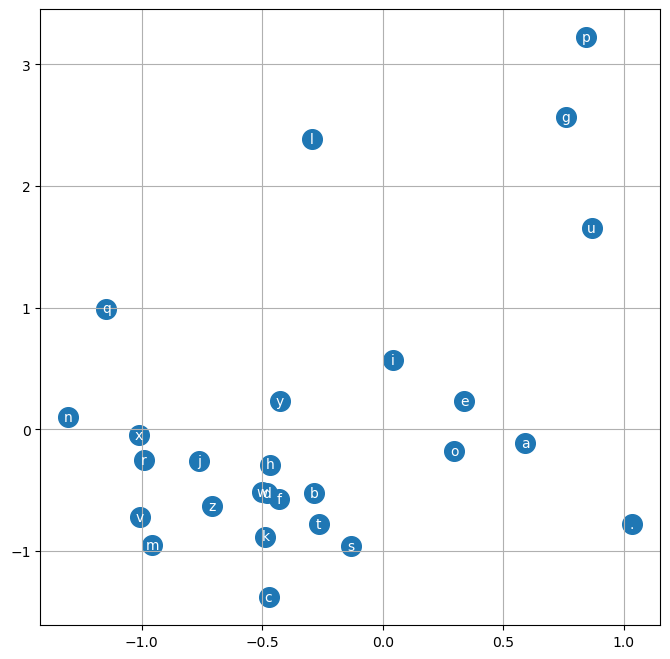

In [121]:
# Visualising the embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]): 
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

p is treated as a special character. points close together are seen as interchangeable/similar 

### How to find the right learning rate
Reset params, try learning rate where its too small eg -0.001 and too big -1(unstable). Create set of lrs between -0.001 and -1, and try for all of them

In [77]:
lre = torch.linspace(-3, 0, 1000) # test lr from 10^-3 to 10^0
lrs = 10**lre

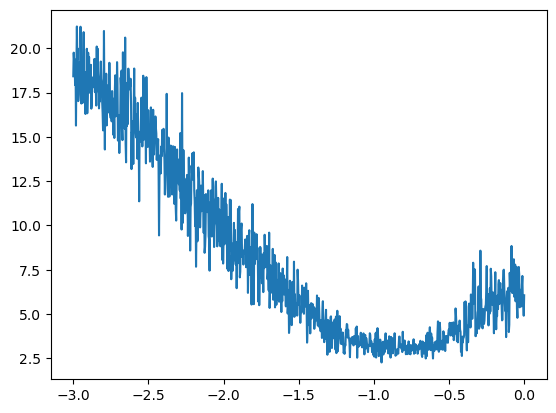

In [ ]:
# Gradient descent, testing learning rates  

# lr trackers
lri = []
lossi = []

for i in range(1000): 
    
    # minibatch construct: random batch of 32
    ix = torch.randint(0, Xtr.shape[0], (32,)) 

    # forward pass 
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) 

    # backward pass 
    for p in parameters: 
        p.grad = None
    loss.backward()

    # update 
    lr = lrs[i]
    for p in parameters: 
        p.data += -lr * p.grad

    # track
    lri.append(lre[i])
    lossi.append(loss.item())

plt.plot(lri, lossi)

This means a good lre is -1.0, meaning 10**-1 = 0.1.